In [1]:
using QuantEcon, CairoMakie, CUDA

In [2]:
CUDA.name(CUDA.device())

"NVIDIA GeForce RTX 3080 Ti Laptop GPU"

In [3]:
max_threads_per_block = CUDA.attribute(CUDA.device(), CUDA.DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK)

1024

In [56]:
function params(;nk = 101)
    
    # Create NamedTuple
    p = (α = 0.33, # Capital share
         β = 0.9, # Discount factor
         A = 1.0, # TFP
         δ = 0.1, # Depreciation rate
         kmin = 0.75, # Minimum capital
         kmax = 1.25, # Maximum capital
         θ = 1.0, # Grid expansion parameter
         γ = 1.0, # Risk aversion
         kgrid = zeros(Float32, nk), # Capital grid
         maxiter = 1000, # Maximum number of iterations
         tol = 1e-5, # Tolerance
         print_skip = 10) # Print every print_skip iterations

    # Compute steady state capital
    Kss = ((p.A*p.α*p.β)/(1-p.β*(1.0-p.δ)))^(1/(1.0-p.α))

    # Create capital grid
    temp_grid = LinRange(0, 1, nk)
    kgrid = p.kmin*Kss .+ (p.kmax*Kss - p.kmin*Kss) * temp_grid.^p.θ
    
    # Return new NamedTuple
    p = (p..., kgrid = kgrid)
    
    return p
end

params (generic function with 1 method)

In [57]:
function vfi(p::NamedTuple)

    # Get params
    maxiter = p.maxiter
    tol = p.tol
    γ = p.γ
    β = p.β
    A = p.A 
    δ = p.δ
    α = p.α
    nk = length(p.kgrid)
    print_skip = p.print_skip

    # Create CuArrays
    V_d = CuArray{Float32}(zeros(nk))
    Vmax_d = CuArray{Float32}(zeros(nk))
    pol_d = CuArray{Int32}(zeros(nk))
    pol_idx_d = CuArray{CartesianIndex{2}}(undef, nk, 1)
    Vnew_d = CuArray{Float32}(zeros(length(p.kgrid),length(p.kgrid)))
    
    kgrid_d = CuArray(p.kgrid)
    
    # Initialise consumption
    cons_d = A .* kgrid_d.^α .+ (1 - δ) .* kgrid_d .- kgrid_d'
    
    # Run VFI
    solve!(V_d, Vnew_d, Vmax_d, cons_d, pol_d, pol_idx_d, kgrid_d; maxiter = maxiter, tol = tol, γ = γ, β = β, nk = nk, print_skip = print_skip)
    return V_d, pol_d, kgrid_d
end

function solve!(V, Vnew, Vmax, cons, pol, pol_idx, grid; maxiter, tol, γ, β, nk, print_skip = print_skip)
    error = tol + 1.0
    iter = 0
    pos_c = cons .> 0
    cons[.!pos_c] .= 0
    c = (γ == 1.0 ? log.(cons) : (cons.^(1 - γ) .- 1) ./ (1 - γ))
    while ((error > tol) && (iter < maxiter))
        Vnew = c .+ β .* V'
        Vmax = maximum(Vnew, dims = 2)
        pol_idx = argmax(Vnew, dims = 2)
        pol .= map(x -> x[2], pol_idx)
        error = maximum(abs.(Vmax .- V))
        V .= Vmax
        if iter % print_skip == 0
            println("-------------------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("-------------------------------")
    println("Converged in $iter iterations")
    return V, pol
end

solve! (generic function with 1 method)

In [74]:
psmall = params(nk = 128)

@time begin
    v_d_128, pol_d_128, grid_d_128 = vfi(psmall)
end

(Float32[-0.065463826, -0.055615753, -0.045804407, -0.03603466, -0.026297681, -0.016610118, -0.0069437115, 0.0026904931, 0.012290374, 0.02185592  …  0.91317683, 0.9202716, 0.9273556, 0.9344238, 0.94146955, 0.9484925, 0.9555087, 0.96251255, 0.9695015, 0.97646755], Int32[12, 13, 14, 15, 16, 16, 17, 18, 19, 20  …  109, 109, 110, 111, 112, 112, 113, 114, 115, 116], [1.4608907979175192, 1.4685595160168237, 1.4762282341161284, 1.4838969522154328, 1.4915656703147375, 1.499234388414042, 1.5069031065133465, 1.5145718246126512, 1.5222405427119556, 1.5299092608112603  …  2.365799533635458, 2.3734682517347623, 2.381136969834067, 2.3888056879333717, 2.396474406032676, 2.4041431241319806, 2.4118118422312853, 2.41948056033059, 2.4271492784298943, 2.434817996529199])

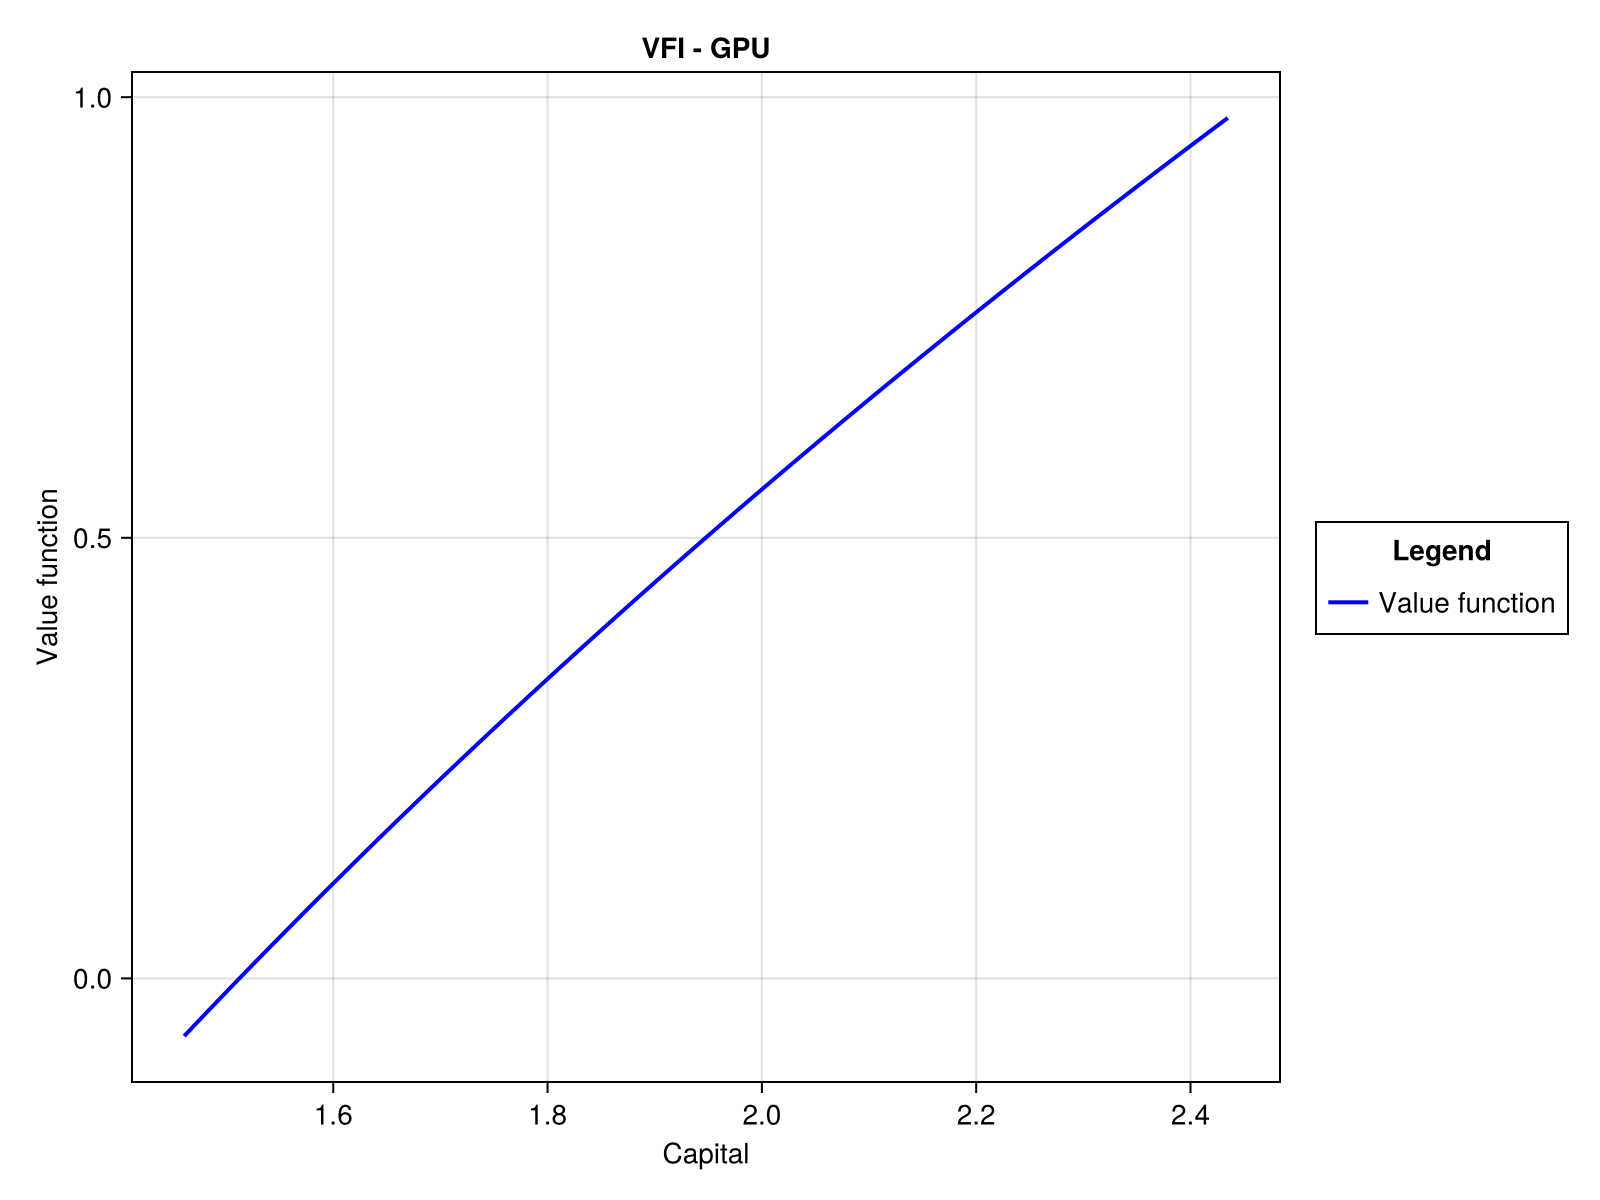

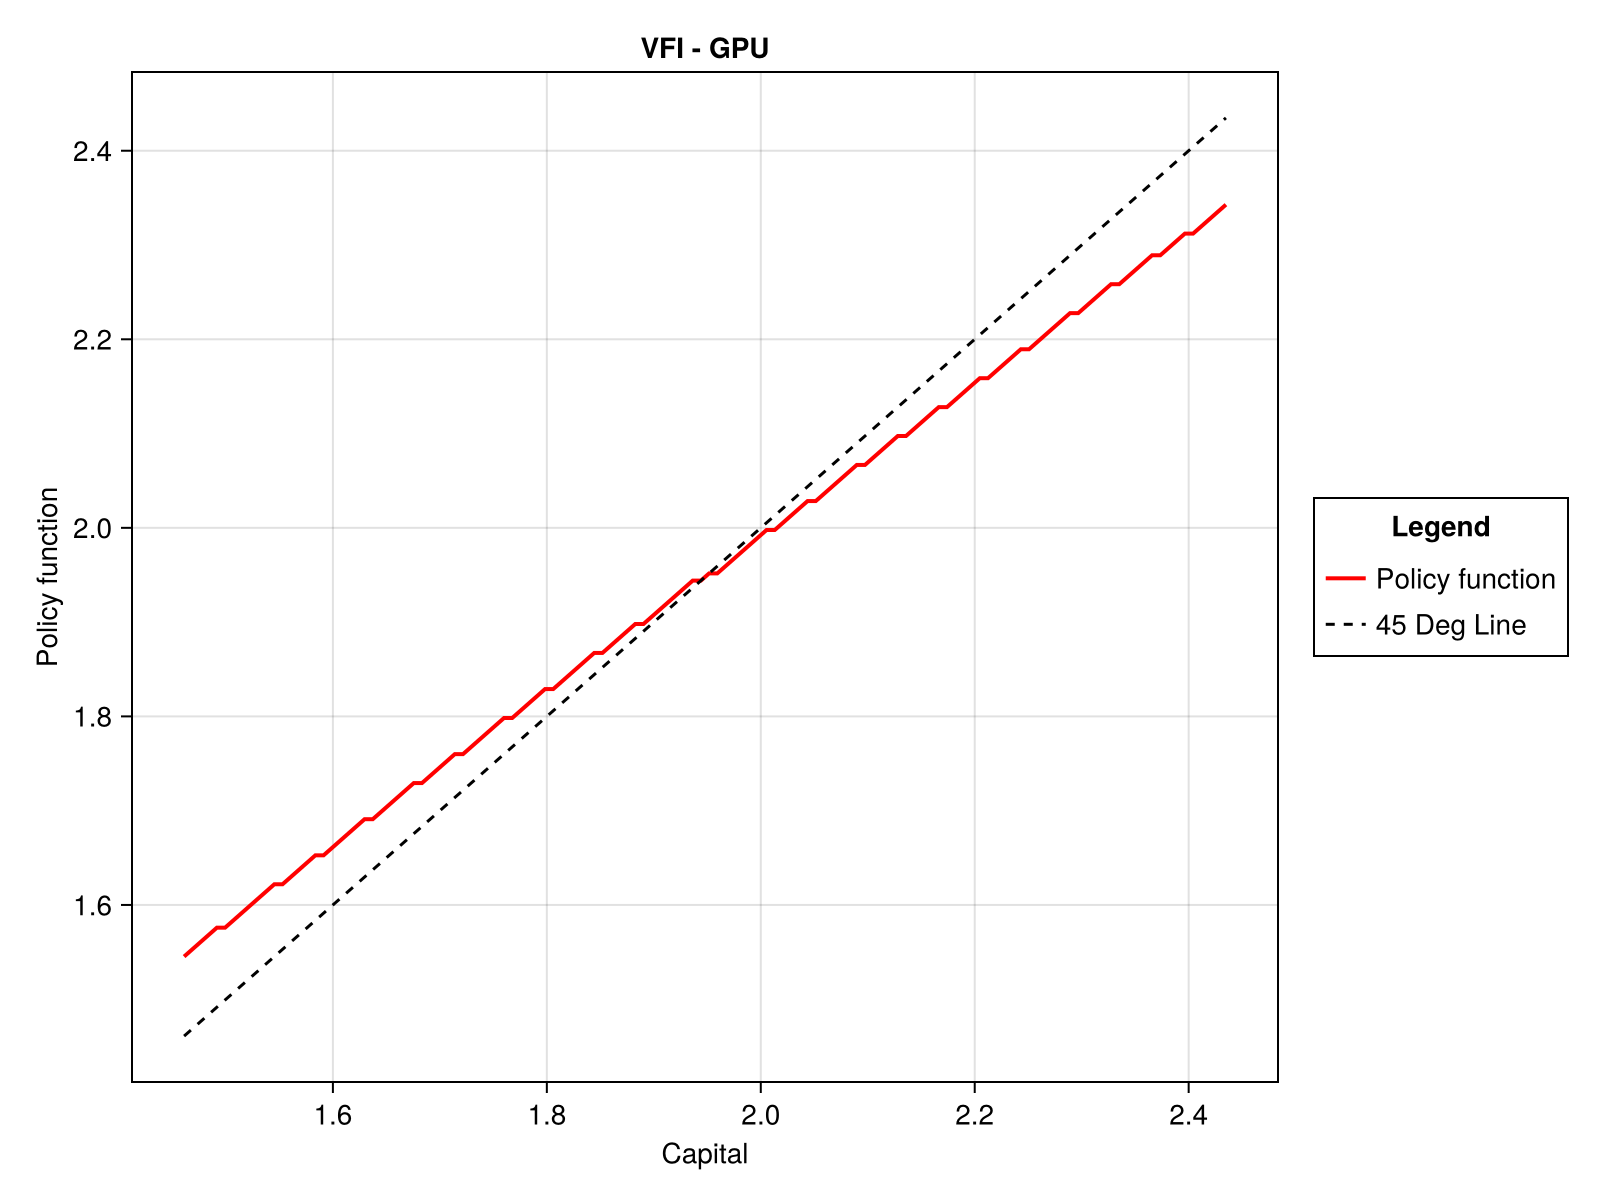

In [73]:
v_128 = Array(v_d_128)
p_128 = Array(pol_d_128)
g_128 = Array(grid_d_128)

fig_v_128 = Figure(size = (800,600))
ax_v_128 = Axis(fig_v_128[1,1], xlabel = "Capital", ylabel = "Value function", title = "VFI - GPU")
lines!(ax_v_128, g_128, v_128, color = :blue, label = "Value function", linewidth = 2)
legendp = Legend(fig_v_128[1,2], ax_v_128, "Legend", orientation = :vertical)
display(fig_v_128)  

fig_p_128 = Figure(size = (800,600))
ax_p_128 = Axis(fig_p_128[1,1], xlabel = "Capital", ylabel = "Policy function", title = "VFI - GPU")
lines!(ax_p_128, g_128, g_128[p_128], color = :red, linewidth = 2, label = "Policy function")
lines!(ax_p_128, g_128, g_128, color = :black, label = "45 Deg Line", linestyle = :dash)
legendp = Legend(fig_p_128[1,2], ax_p_128, "Legend", orientation = :vertical)
fig_p_128

In [75]:
pbig = params(nk = 1024)

@time begin
    v_d_1024, pol_d_1024, grid_d_1024 = vfi(pbig)
end

(Float32[-0.0654198, -0.06419659, -0.06297398, -0.06175186, -0.060530223, -0.059309132, -0.058088534, -0.05686864, -0.055649377, -0.05443061  …  0.96870387, 0.96957034, 0.9704366, 0.97130245, 0.9721679, 0.9730333, 0.9738986, 0.9747635, 0.97562826, 0.9764927], Int32[93, 94, 95, 96, 96, 97, 98, 99, 100, 100  …  919, 919, 920, 921, 921, 922, 923, 924, 925, 926], [1.4608907979175192, 1.4618428284146958, 1.4627948589118724, 1.463746889409049, 1.4646989199062257, 1.4656509504034023, 1.466602980900579, 1.4675550113977556, 1.4685070418949322, 1.4694590723921088  …  2.4262497220546093, 2.427201752551786, 2.4281537830489626, 2.429105813546139, 2.430057844043316, 2.4310098745404924, 2.431961905037669, 2.4329139355348457, 2.4338659660320223, 2.434817996529199])

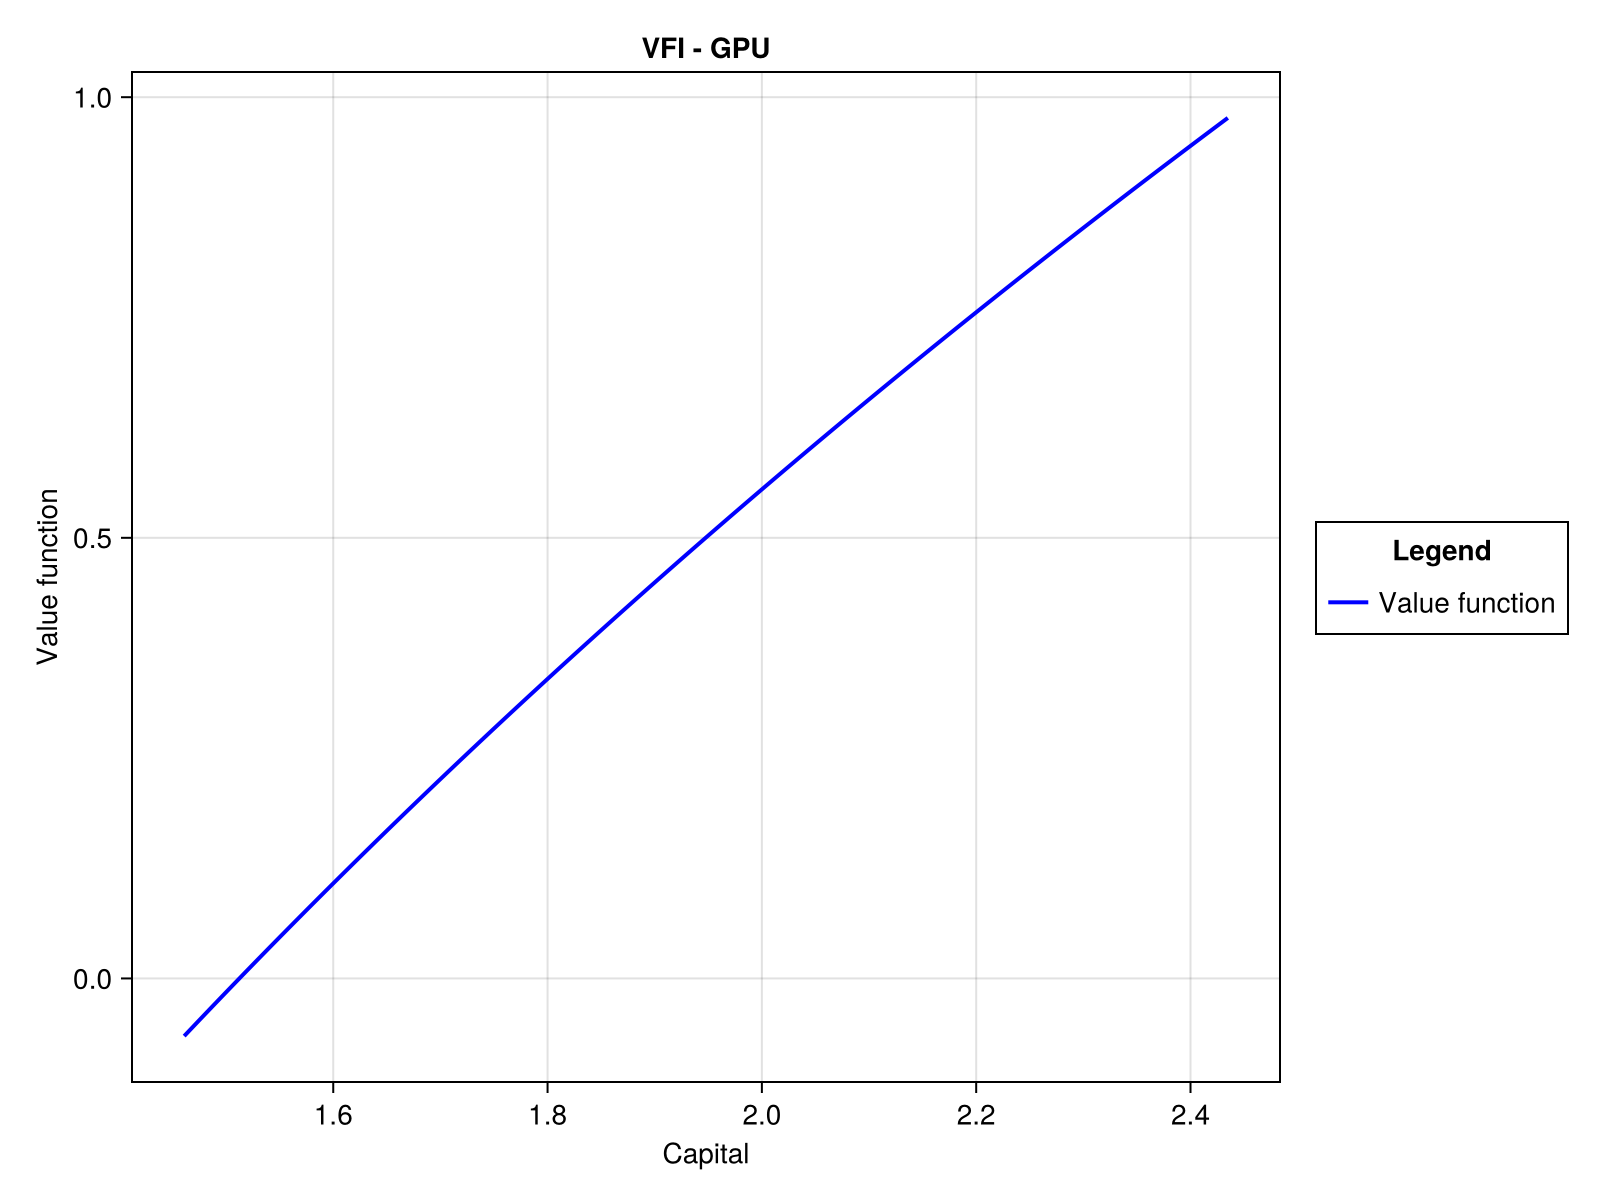

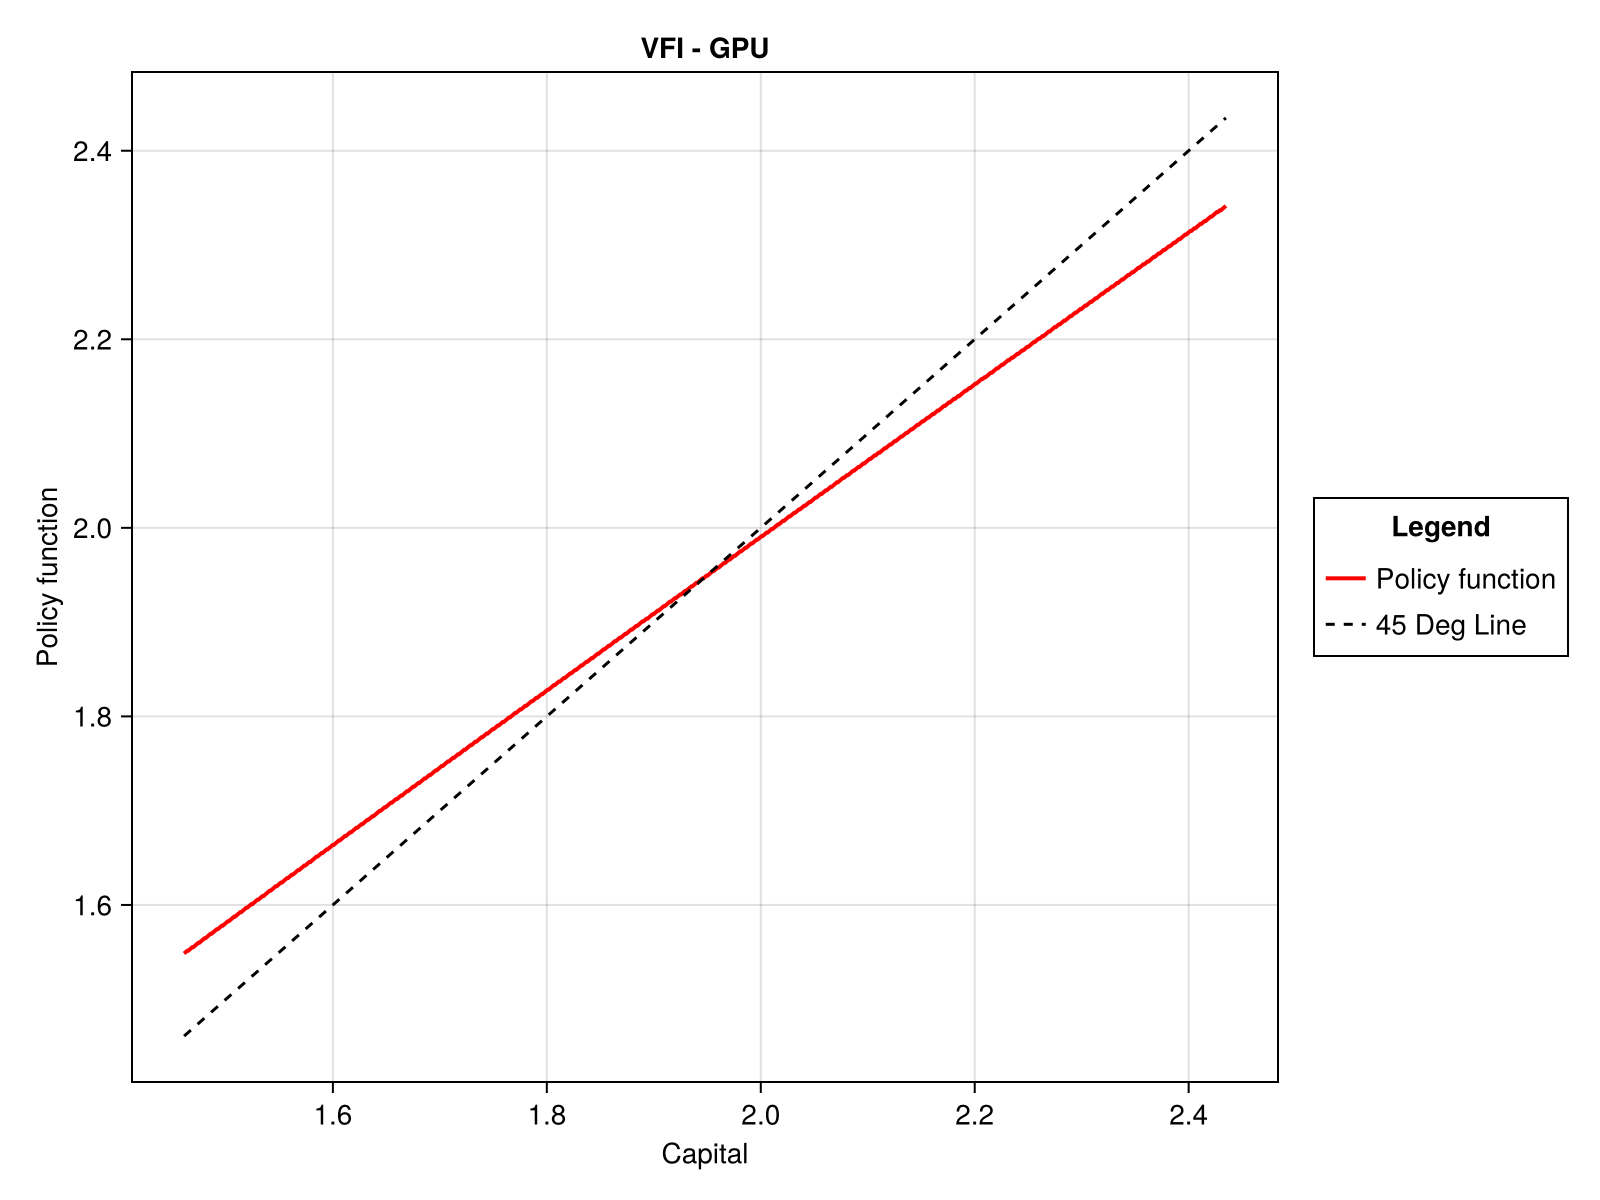

In [76]:
v_1024 = Array(v_d_1024)
p_1024 = Array(pol_d_1024)
g_1024 = Array(grid_d_1024)

fig_v_1024 = Figure(size = (800,600))
ax_v_1024 = Axis(fig_v_1024[1,1], xlabel = "Capital", ylabel = "Value function", title = "VFI - GPU")
lines!(ax_v_1024, g_1024, v_1024, color = :blue, label = "Value function", linewidth = 2)
legendp = Legend(fig_v_1024[1,2], ax_v_1024, "Legend", orientation = :vertical)
display(fig_v_1024)

fig_p_1024 = Figure(size = (800,600))
ax_p_1024 = Axis(fig_p_1024[1,1], xlabel = "Capital", ylabel = "Policy function", title = "VFI - GPU")
lines!(ax_p_1024, g_1024, g_1024[p_1024], color = :red, linewidth = 2, label = "Policy function")
lines!(ax_p_1024, g_1024, g_1024, color = :black, label = "45 Deg Line", linestyle = :dash)
legendp = Legend(fig_p_1024[1,2], ax_p_1024, "Legend", orientation = :vertical)
fig_p_1024

In [77]:
phuge = params(nk = 4096)

@time begin
    v_d_4096, pol_d_4096, grid_d_4096 = vfi(phuge)
end

(Float32[-0.06541929, -0.06511367, -0.06480807, -0.06450251, -0.06419697, -0.063891485, -0.063586034, -0.0632806, -0.06297521, -0.06266985  …  0.9745491, 0.9747651, 0.9749812, 0.9751972, 0.9754132, 0.9756292, 0.9758452, 0.9760612, 0.9762772, 0.9764931], Int32[369, 370, 371, 372, 373, 374, 374, 375, 376, 377  …  3695, 3695, 3697, 3697, 3698, 3699, 3700, 3701, 3701, 3702], [1.4608907979175192, 1.4611286311772533, 1.4613664644369877, 1.4616042976967218, 1.4618421309564562, 1.4620799642161904, 1.4623177974759245, 1.4625556307356589, 1.462793463995393, 1.4630312972551274  …  2.432677497191591, 2.4329153304513254, 2.4331531637110593, 2.4333909969707936, 2.4336288302305276, 2.433866663490262, 2.4341044967499963, 2.4343423300097307, 2.4345801632694646, 2.434817996529199])

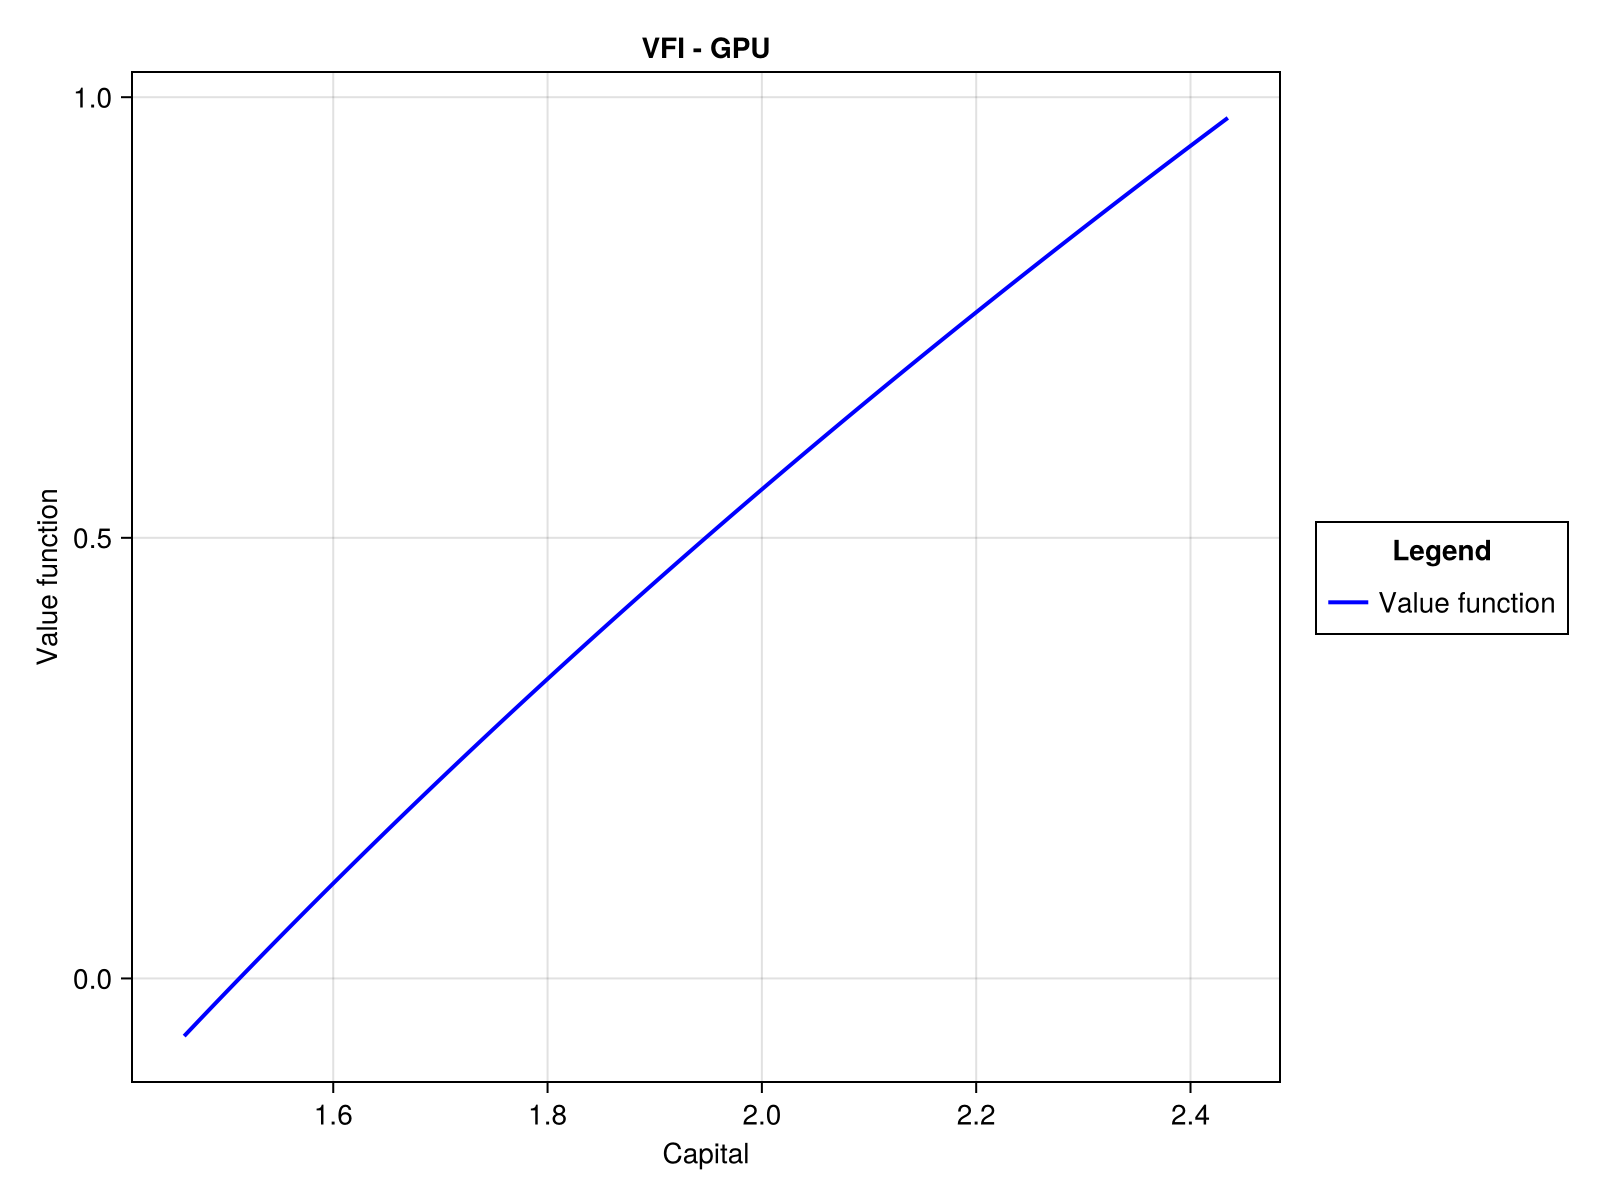

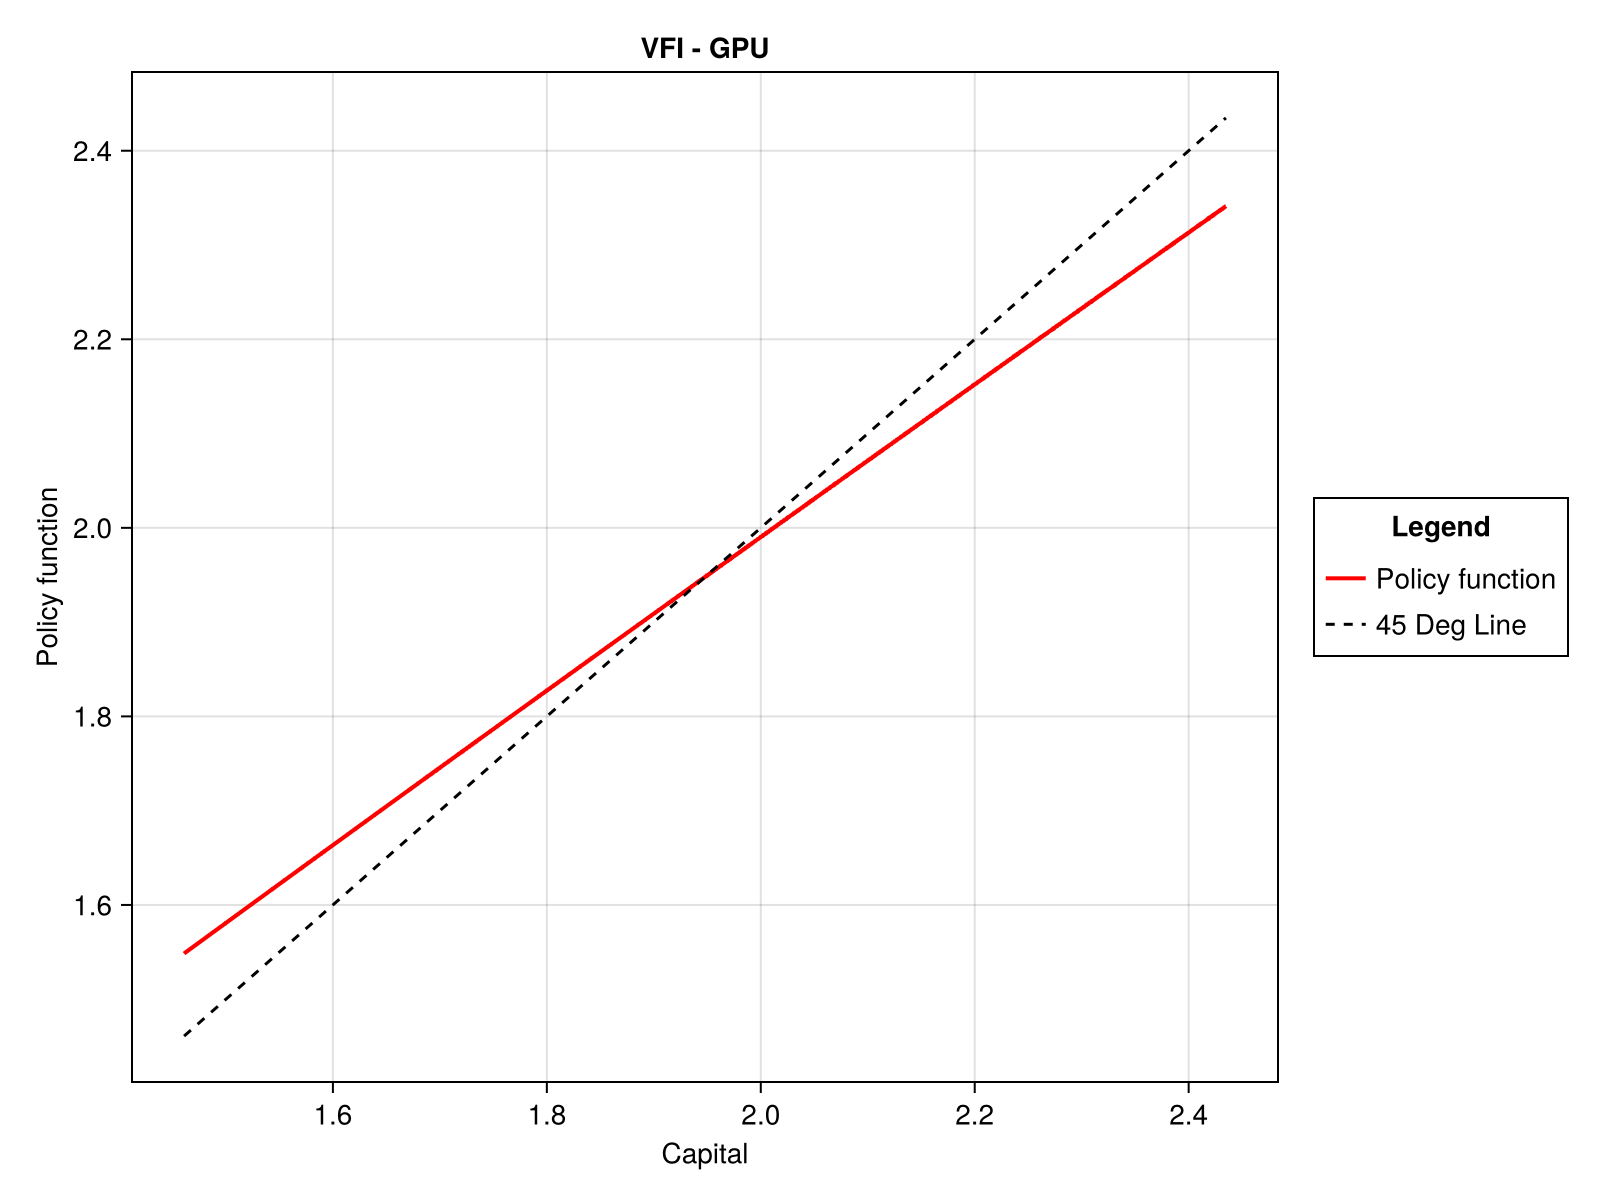

In [78]:
v_4096 = Array(v_d_4096)
p_4096 = Array(pol_d_4096)
g_4096 = Array(grid_d_4096)

fig_v_4096 = Figure(size = (800,600))
ax_v_4096 = Axis(fig_v_4096[1,1], xlabel = "Capital", ylabel = "Value function", title = "VFI - GPU")
lines!(ax_v_4096, g_4096, v_4096, color = :blue, label = "Value function", linewidth = 2)
legendp = Legend(fig_v_4096[1,2], ax_v_4096, "Legend", orientation = :vertical)
display(fig_v_4096)

fig_p_4096 = Figure(size = (800,600))
ax_p_4096 = Axis(fig_p_4096[1,1], xlabel = "Capital", ylabel = "Policy function", title = "VFI - GPU")
lines!(ax_p_4096, g_4096, g_4096[p_4096], color = :red, linewidth = 2, label = "Policy function")
lines!(ax_p_4096, g_4096, g_4096, color = :black, label = "45 Deg Line", linestyle = :dash)
legendp = Legend(fig_p_4096[1,2], ax_p_4096, "Legend", orientation = :vertical)
fig_p_4096

In [80]:
function pars(;nk = 101, nz = 15)
    
    # Create NamedTuple
    p = (;α = 0.33, # Capital share
    β = 0.9, # Discount factor
    δ = 0.1, # Depreciation Rate
    A = 1.0, # TFP
    μ = 0.0, # Mean of AR(1) process
    σ = 0.003, # Standard deviation of AR(1) process
    ρ = 0.9, # Persistence of AR(1) process
    Π = zeros(Float32, nz, nz), # Transition matrix
    zgrid = zeros(Float32, nz), # Grid for productivity
    kgrid = zeros(Float32, nk), # Grid for capital
    kmin = 1e-2, # Minimum capital 
    kmax = 10.0, # Maximum capital
    θ = 1.0, # Grid expansion parameter
    γ = 1.0, # Risk aversion 
    maxiter = 1000, # Maximum number of iterations
    tol = 1e-5, # Tolerance
    print_skip = 10) # Print every print_skip iterations

    # Create grid for productivity
    mc = rouwenhorst(nz, p.μ, p.ρ, p.σ)
    Π = mc.p
    zgrid = exp.(mc.state_values)

    # Create grid for Capital
    temp_grid = LinRange(0, 1, nk)
    kgrid = p.kmin .+ (p.kmax .- p.kmin) .* temp_grid.^p.θ

    # Return new NamedTuple
    p = (p..., Π = Π, zgrid = zgrid, kgrid = kgrid)

    return p
end

p = pars(nk = 256, nz = 15)

(α = 0.33, β = 0.9, δ = 0.1, A = 1.0, μ = 0.0, σ = 0.003, ρ = 0.9, Π = [6.103515625e-5 0.0008544921875 … 0.0008544921875 6.103515625e-5; 6.103515625e-5 0.0008544921875 … 0.0008544921875 6.103515625e-5; … ; 6.103515625e-5 0.0008544921875 … 0.0008544921875 6.103515625e-5; 6.103515625e-5 0.0008544921875 … 0.0008544921875 6.103515625e-5], zgrid = [0.03457959025122844, 0.05594303083042085, 0.09050490985451279, 0.14641928737474275, 0.23687784176339377, 0.3832221350379456, 0.6199786509779679, 1.003004504503377, 1.6226656102869836, 2.625156388616362, 4.246990890177603, 6.870802707018247, 11.115618342377728, 17.982901911474734, 29.092826975250997], kgrid = [0.01, 0.049176470588235294, 0.08835294117647058, 0.1275294117647059, 0.16670588235294118, 0.2058823529411765, 0.24505882352941177, 0.2842352941176471, 0.32341176470588234, 0.36258823529411766  …  9.647411764705883, 9.686588235294117, 9.725764705882353, 9.764941176470588, 9.804117647058822, 9.843294117647059, 9.882470588235295, 9.921647058823

In [81]:
function vfi_stochastic(p::NamedTuple)

    # Get params
    maxiter = p.maxiter
    tol = p.tol
    A = p.A 
    δ = p.δ
    α = p.α
    γ = p.γ
    β = p.β
    nk = length(p.kgrid)
    nz = length(p.zgrid)
    print_skip = p.print_skip
    n = nk * nz * nk
    
    # Create CuArrays
    V_d = CuArray{Float32}(zeros(nk, nz))
    Vnew_d = CuArray{Float32}(zeros(nk, nz, nk))
    pol_d = CuArray{Int32}(zeros(nk, nz))
    pol_idx_d = CuArray{CartesianIndex{3}}(undef, nk, nz, nk)
    EV_d = CuArray{Float32}(zeros(nk, nz))
    Vmax_d = CuArray{Float32}(zeros(nk, nz))

    kgrid_d = CuArray(p.kgrid)
    zgrid_d = CuArray(p.zgrid)
    Π_d = CuArray(p.Π)

    # Initialise production and consumption 
    prod_d = A .* zgrid_d' .* kgrid_d.^α .+ (1 - δ) .* kgrid_d
    kgrid_d = reshape(kgrid_d, 1, 1, nk)
    cons_d = prod_d .- kgrid_d
    kgrid_d = reshape(kgrid_d, nk)
    
    # Run VFI
    solve_stochastic!(V_d, Vnew_d, Vmax_d, EV_d, cons_d, pol_d, pol_idx_d, kgrid_d, Π_d; maxiter = maxiter, tol = tol, γ = γ, β = β, n = n, nk = nk, nz = nz, print_skip = print_skip)

    return V_d, pol_d, kgrid_d
end

function solve_stochastic!(V, Vnew, Vmax, EV, cons, pol, pol_idx, grid, Π; maxiter, tol, γ, β, n, nk, nz, print_skip = print_skip)
    error = tol + 1.0
    iter = 0
    pos_c = cons .> 0
    cons[.!pos_c] .= 0
    c = (γ == 1.0 ? log.(cons) : (cons.^(1 - γ) .- 1) ./ (1 - γ))
    while ((error > tol) && (iter < maxiter))
        EV = Π * V'
        Vnew = c .+ β .* EV'
        Vmax = maximum(Vnew, dims = 3)
        pol_idx = argmax(Vnew, dims = 3)
        pol .= map(x -> x[3], pol_idx)
        error = maximum(abs.(Vmax .- V))
        V .= Vmax
        if iter % print_skip == 0
            println("-------------------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("-------------------------------")
    println("Converged in $iter iterations")
    return V, pol
end

solve_stochastic! (generic function with 1 method)

In [82]:
@time begin
    out_v, out_pol, out_grid = vfi_stochastic(p)
end

(Float32[-18.737991 -18.200382 … -12.342556 -11.861389; -10.87465 -10.719347 … -5.9177403 -5.4386277; … ; 24.427448 24.43249 … 26.084658 26.49077; 24.461372 24.4664 … 26.116468 26.522413], Int32[1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1], [0.01, 0.049176470588235294, 0.08835294117647058, 0.1275294117647059, 0.16670588235294118, 0.2058823529411765, 0.24505882352941177, 0.2842352941176471, 0.32341176470588234, 0.36258823529411766  …  9.647411764705883, 9.686588235294117, 9.725764705882353, 9.764941176470588, 9.804117647058822, 9.843294117647059, 9.882470588235295, 9.92164705882353, 9.960823529411766, 10.0])

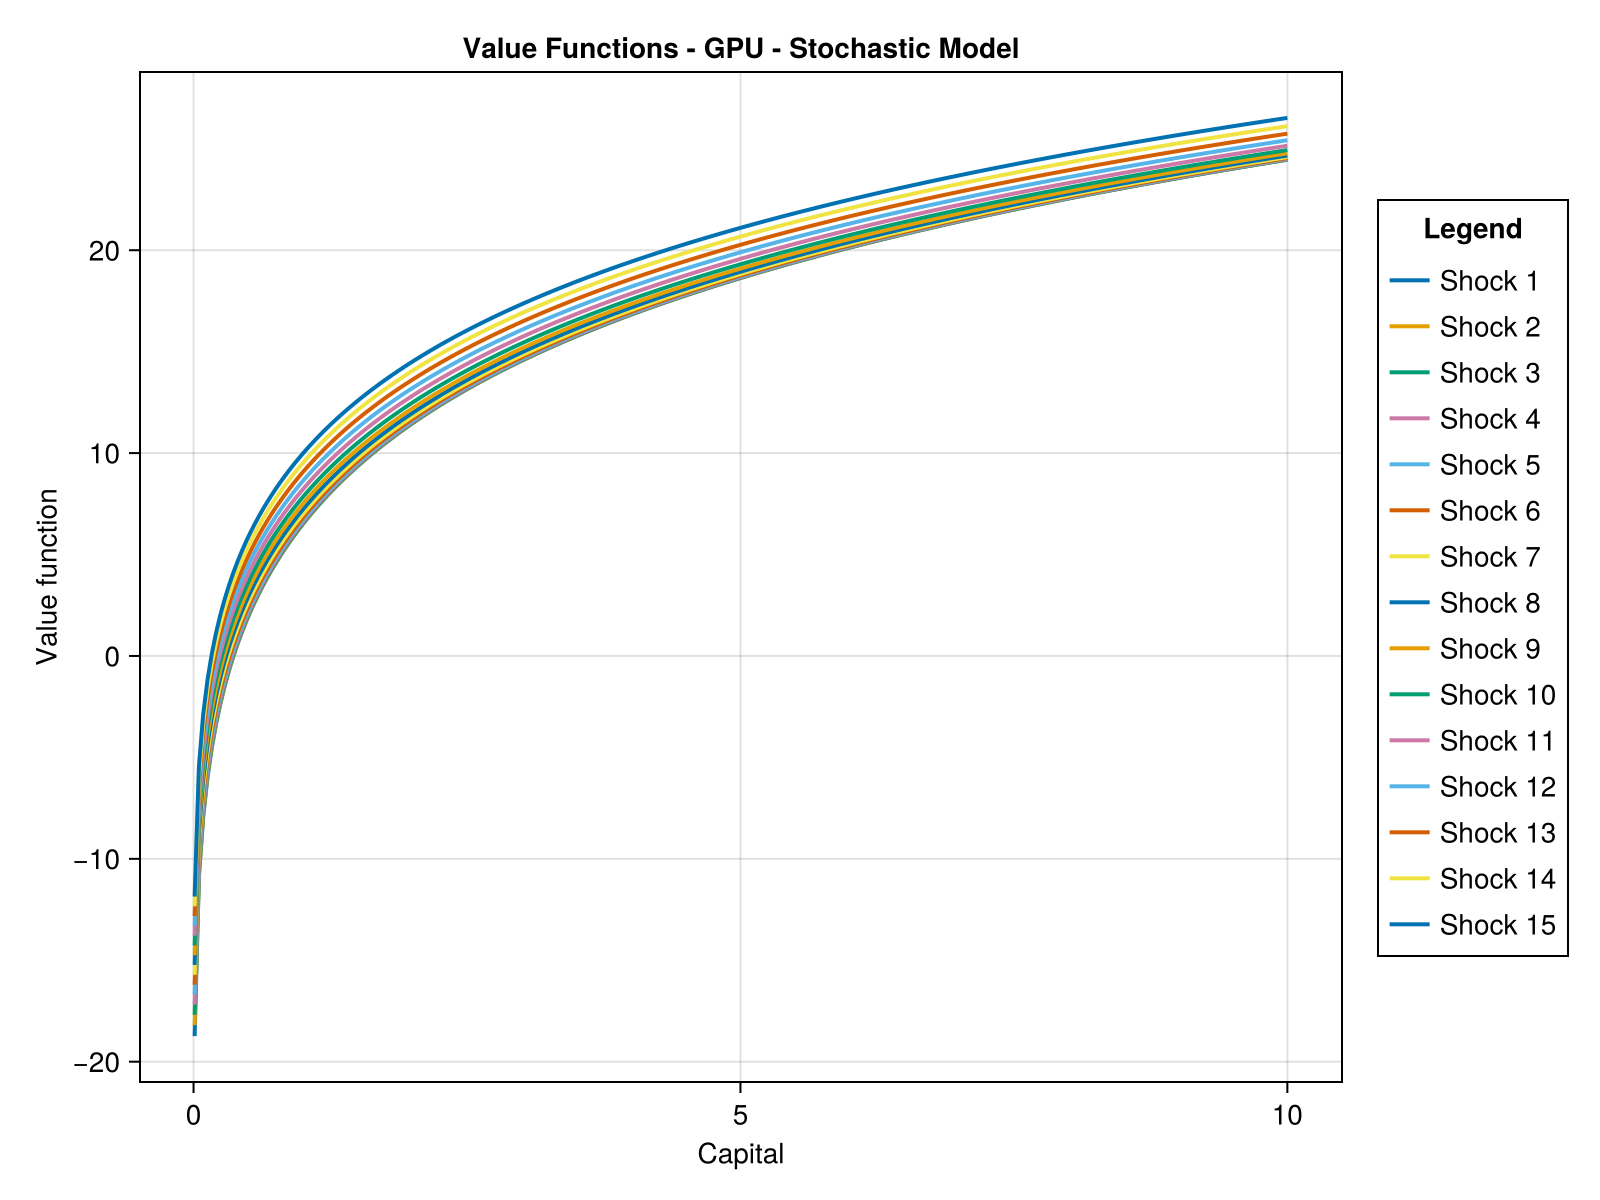

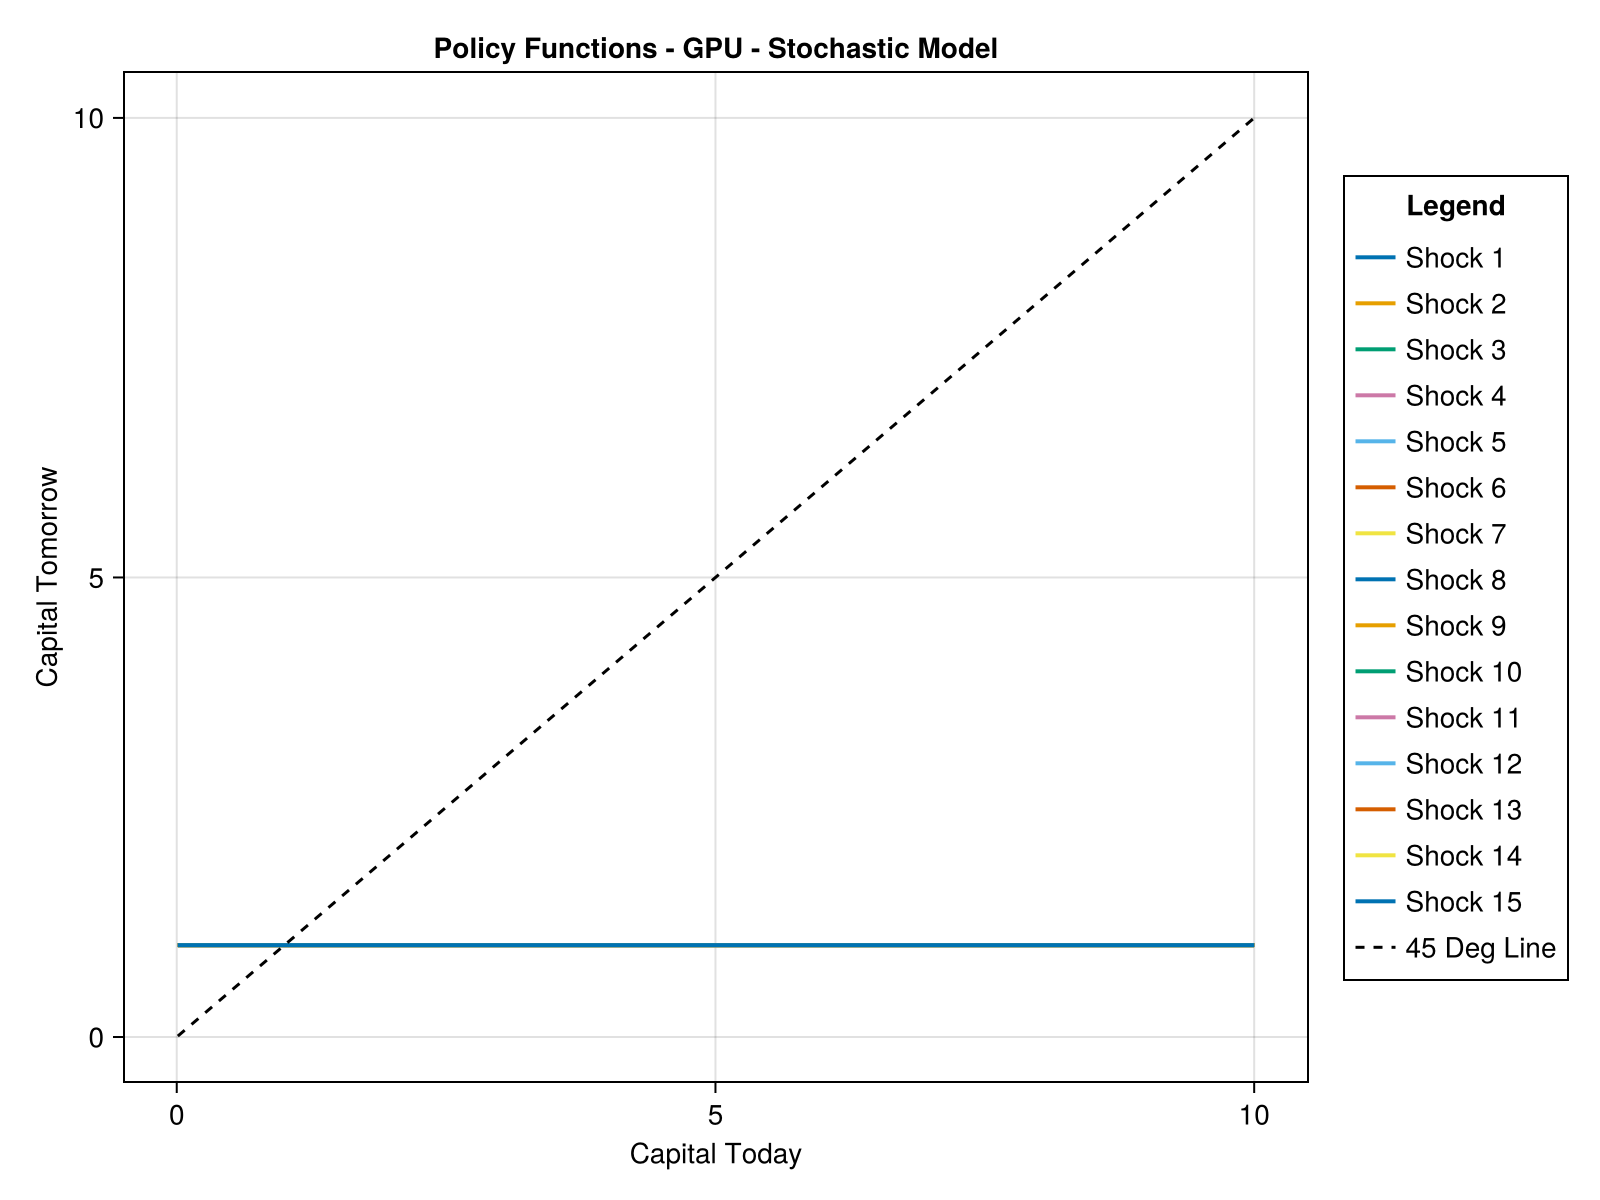

In [83]:
v_stochastic = Array(out_v)
p_stochastic = Array(out_pol)
g_stochastic = Array(out_grid)

fig_v_stochastic = Figure(size = (800,600))
ax_v_stochastic = Axis(fig_v_stochastic[1,1], xlabel = "Capital", ylabel = "Value function", title = "Value Functions - GPU - Stochastic Model")
for j in 1:length(p.zgrid)
    lines!(ax_v_stochastic, g_stochastic, v_stochastic[:,j], linewidth = 2, label = "Shock $j")
end
legendp = Legend(fig_v_stochastic[1,2], ax_v_stochastic, "Legend", orientation = :vertical)
display(fig_v_stochastic)

fig_p_stochastic = Figure(size = (800,600))
ax_p_stochastic = Axis(fig_p_stochastic[1,1], xlabel = "Capital Today", ylabel = "Capital Tomorrow", title = "Policy Functions - GPU - Stochastic Model")
for j in 1:length(p.zgrid)
    lines!(ax_p_stochastic, g_stochastic, p_stochastic[:,j], linewidth = 2, label = "Shock $j")
end
lines!(ax_p_stochastic, g_stochastic, g_stochastic, color = :black, label = "45 Deg Line", linestyle = :dash)
legendp = Legend(fig_p_stochastic[1,2], ax_p_stochastic, "Legend", orientation = :vertical)
fig_p_stochastic